# This notebook is analzying the spectral parameters from the frontal EEG channels pre and post MST.

We are only including frontal because we are basing our analyses off of Smith, 2022, in which their dataset only uses fronto-central channels. Additionally, the treatment is targeted to frontal/central areas.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
from statsmodels.formula.api import ols
from scipy.stats import ttest_rel
from pingouin import ttest, normality, wilcoxon

from mst_plotting_functions import plot_feature_prepost
from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

In [3]:
%matplotlib inline

### Functions

In [4]:
def perm_test(df, feature='', nreps=10000, seed=256, plot_hist=True, run_ttest=True):
    '''permutation test from https://www.uvm.edu/\~statdhtx/StatPages/\
    ResamplingWithR/RandomMatchedSample/RandomMatchedSampleR.html
    '''
    
    means_pre = df[df['pre_post']=='pre'][feature].values
    means_post = df[df['pre_post']=='post'][feature].values
    
    diff_obt = np.nanmedian(means_post) - np.nanmedian(means_pre)
    difference = means_post-means_pre
    
    np.random.seed(seed)
    resamp_mean_diff = np.zeros(nreps)

    for i in range(0, nreps):
        signs = np.random.choice([1, -1], len(difference), replace=True)
        resamp = difference * signs
        resamp_mean_diff[i] = np.nanmedian(resamp)

    diff_obt = abs(diff_obt)
    highprob = len(resamp_mean_diff[resamp_mean_diff >= diff_obt])/nreps
    lowprob = len(resamp_mean_diff[resamp_mean_diff <= -diff_obt])/nreps
    prob2tailed = lowprob + highprob

    print("The probability from the sampling statistics is = ",prob2tailed,'\n')

    if plot_hist:
        plt.hist(resamp_mean_diff, bins=30);
        plt.title(feature)
        plt.xlabel('Median Difference')
        plt.axvline(x=diff_obt, c='r')
        plt.axvline(x=-diff_obt, c='r')

    # compare to student's t-test
    if run_ttest:
        print(ttest(means_pre, means_post, paired=True))

In [5]:
FRONTAL_ONLY = True

In [6]:
# load dataframe
exp_df = pd.read_csv('../saved_files/mst_files/mst_all_features.csv', index_col = 0)

# Exclude channels from ppn's with bad fits
exp_df_included = exp_df[exp_df['exclude']==False]


In [7]:
# frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
#                     'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
#                     'FC4', 'FC6', 'FT8', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6']

frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
                    'F2', 'F4', 'F6', 'F8', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
                    'FC4', 'FC6']

if FRONTAL_ONLY:
    exp_df_included = exp_df_included[exp_df_included['channel'].isin(frontal_channels)]

## Load SpecParam Fits

In [8]:
fits_pre = np.load('../saved_files/mst_files/mst_fits_pre.npy')
fits_post = np.load('../saved_files/mst_files/mst_fits_post.npy')
freq_axis = np.load('../saved_files/mst_files/mst_freq_axis.npy')

**Correct for excluded fits**

In [9]:
# get boolean area with True to exclude channels from patients
to_exclude_pre = exp_df['exclude'][exp_df['pre_post']=='pre'].values
to_exclude_post = exp_df['exclude'][exp_df['pre_post']=='post'].values

# reshape fits array from [23, 60,99] --> [1390, 99]
fits_pre_flat = fits_pre.reshape(len(to_exclude_pre), fits_pre.shape[2])
fits_post_flat = fits_post.reshape(len(to_exclude_pre), fits_pre.shape[2])

# replace to excluded ones with nans
fits_pre_flat[to_exclude_pre] = np.nan
fits_post_flat[to_exclude_post] = np.nan

# reshape back to original array from  [1390, 99] --> [23, 60,99]
fits_pre_included = fits_pre_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])
fits_post_included = fits_post_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])

## Load PSD's

In [10]:
psd_pre = np.load('../saved_files/mst_files/pre_mst_psd.npy')
psd_post = np.load('../saved_files/mst_files/post_mst_psd.npy')

**Correct for excluded PSD's**

In [11]:
# reshape psd array from [23, 60,99] --> [1390, 99]
psd_pre_flat = psd_pre.reshape(len(to_exclude_pre), psd_pre.shape[2])
psd_post_flat = psd_post.reshape(len(to_exclude_pre), psd_pre.shape[2])

# replace to excluded ones with nans
psd_pre_flat[to_exclude_pre] = np.nan
psd_post_flat[to_exclude_post] = np.nan

# reshape back to original array from  [1390, 99] --> [23, 60,99]
psd_pre_included = psd_pre_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])
psd_post_included = psd_post_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])

### Replace NaN's with 0's for oscillatory amplitude (aperiodic adjusted)

There are so few delta oscillations, that we cannot run statistics (later on) using delta_amp. Therefore, we want to put a value instead of a NaN, and say that no oscillation = 0 mV. 

We may not end up using this no nan dataframe, and simply use permutation testing instead, but keeping this here just in case.

In [12]:
df_include_nonan = exp_df_included.copy()
df_include_nonan['delta_amp'] = df_include_nonan['delta_amp'].fillna(0)
df_include_nonan['theta_amp'] = df_include_nonan['theta_amp'].fillna(0)
df_include_nonan['alpha_amp'] = df_include_nonan['alpha_amp'].fillna(0)
df_include_nonan

,patient,pre_post,channel,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,error,r_squared,exclude
0,9,pre,FP1,NaN,NaN,0.0,-11.280826,5.997988,2.501555,0.667675,-11.313390,9.406764,2.569185,1.072654,-11.309979,-10.794617,1.474183,0.060640,0.986008,False
1,9,pre,FPZ,NaN,NaN,0.0,-11.309185,6.086847,2.554596,0.675706,-11.326472,9.449168,2.497624,1.093702,-11.304463,-10.830635,1.446444,0.060675,0.985659,False
2,9,pre,FP2,NaN,NaN,0.0,-11.282578,NaN,NaN,0.000000,-11.397794,8.785747,5.107161,0.969494,-11.330043,-10.789054,1.503540,0.064948,0.983402,False
3,9,pre,AF3,NaN,NaN,0.0,-11.233921,NaN,NaN,0.000000,-11.164987,10.155171,8.000000,0.969552,-11.276905,-10.821901,1.394998,0.126346,0.952315,False
4,9,pre,AF4,NaN,NaN,0.0,-11.277614,NaN,NaN,0.000000,-11.283093,10.436366,8.000000,0.951637,-11.309732,-10.837673,1.422327,0.119482,0.958271,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,191,post,FC1,NaN,NaN,0.0,-12.082840,NaN,NaN,0.000000,-12.211634,9.364410,3.720658,1.422011,-11.637804,-11.589145,1.298658,0.088705,0.974485,False
2718,191,post,FCZ,NaN,NaN,0.0,-12.052600,NaN,NaN,0.000000,-12.183478,9.077289,3.383321,1.420713,-11.628279,-11.566106,1.312792,0.100002,0.969807,False
2719,191,post,FC2,NaN,NaN,0.0,-12.064956,NaN,NaN,0.000000,-12.189537,9.065957,3.278906,1.397259,-11.621142,-11.597395,1.243688,0.090020,0.972982,False
2720,191,post,FC4,NaN,NaN,0.0,-12.000016,NaN,NaN,0.000000,-12.125550,9.002648,3.125283,1.402986,-11.546800,-11.534847,1.217132,0.069558,0.980245,False


## Averaging Over All (*Frontal*) Electrodes Per Subject

**Average over with amplitudes as 0 (i.e. exp_df_mean_nonan)**

In [13]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_bw', 'alpha_cf']
exp_df_mean_nonan = pd.DataFrame(df_include_nonan.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

**Average over with NaNs (i.e. exp_df_mean)**

In [14]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_bw', 'alpha_cf']
exp_df_mean = pd.DataFrame(exp_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

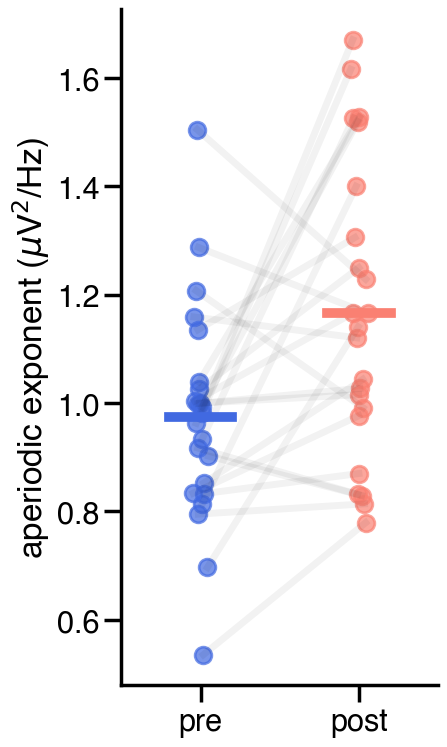

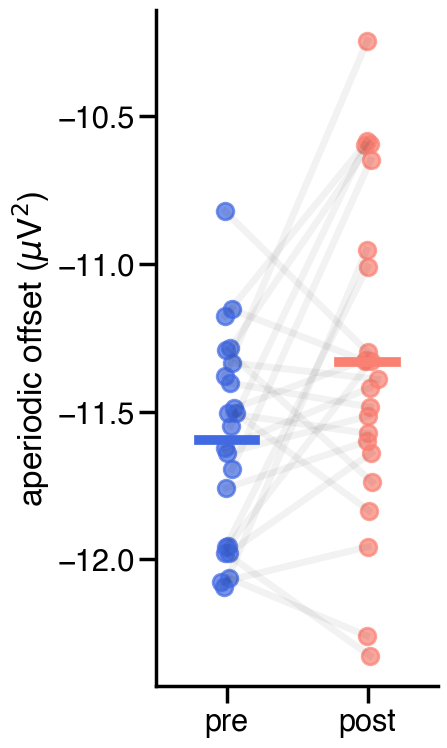

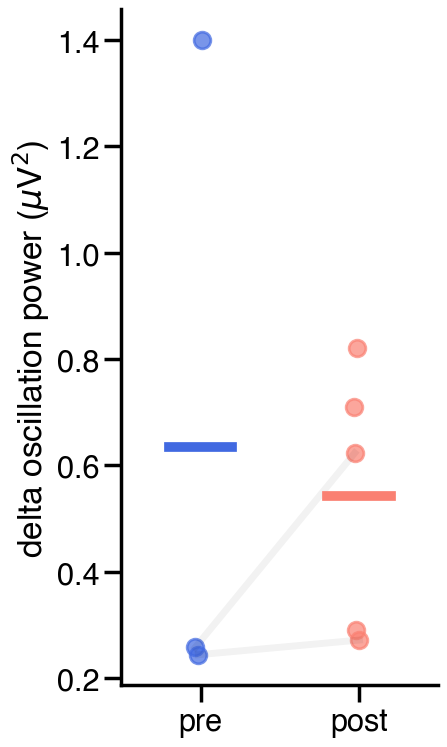

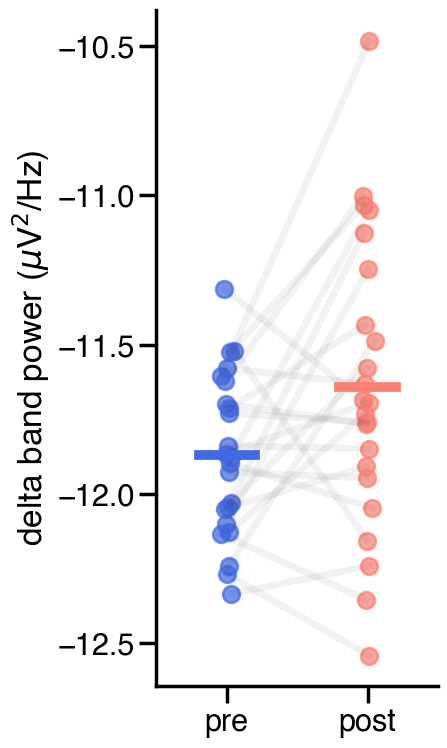

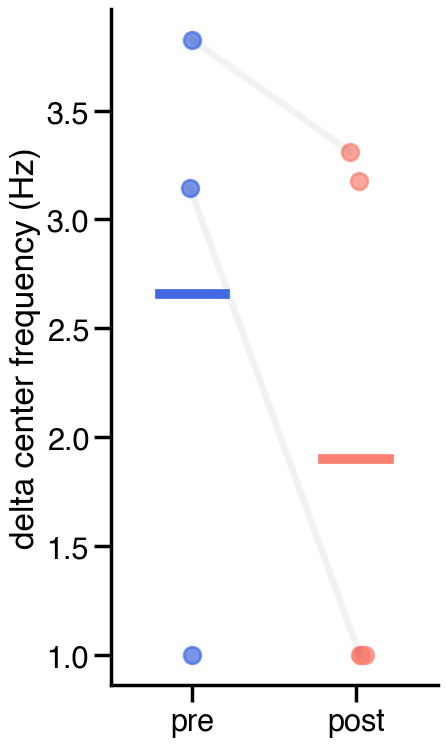

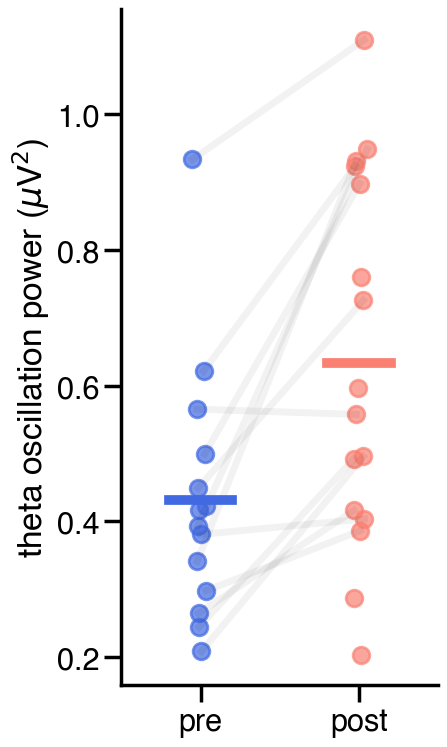

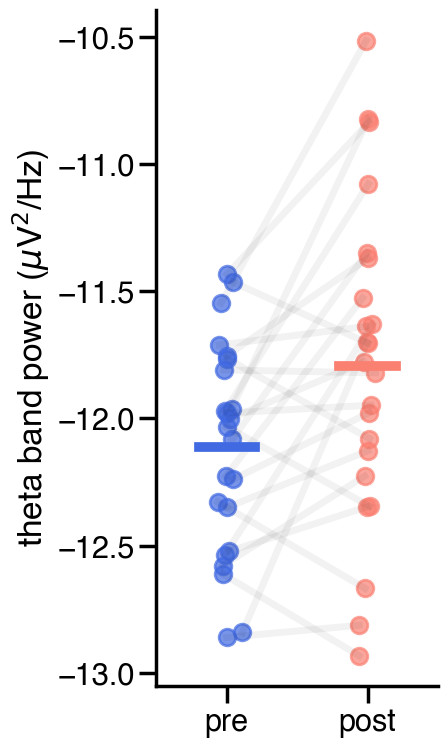

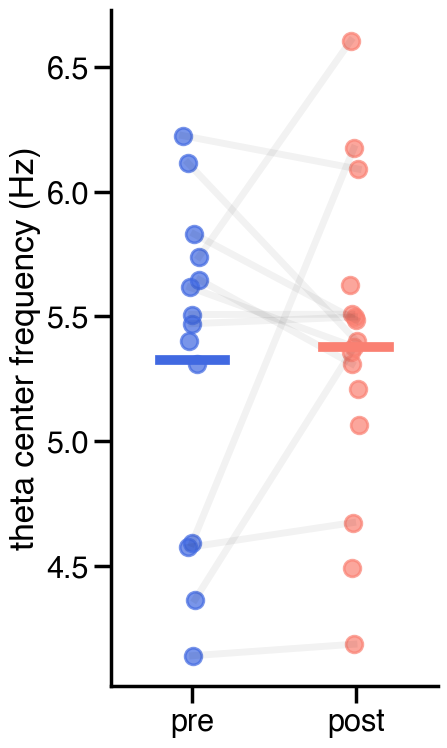

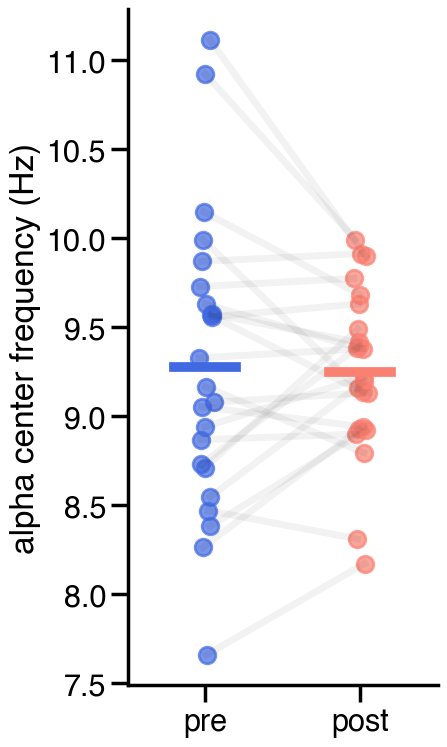

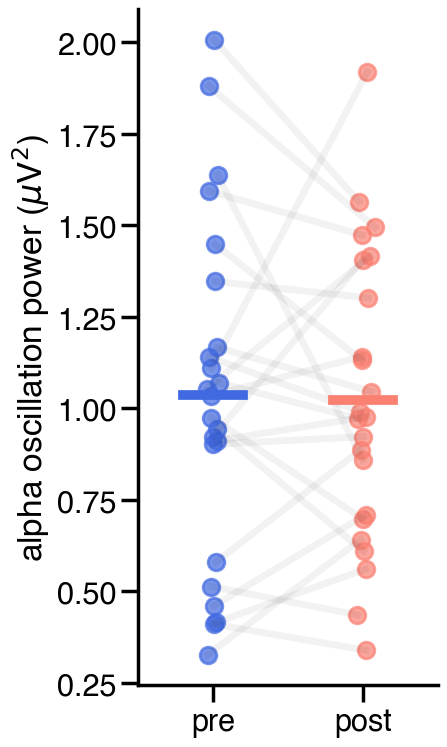

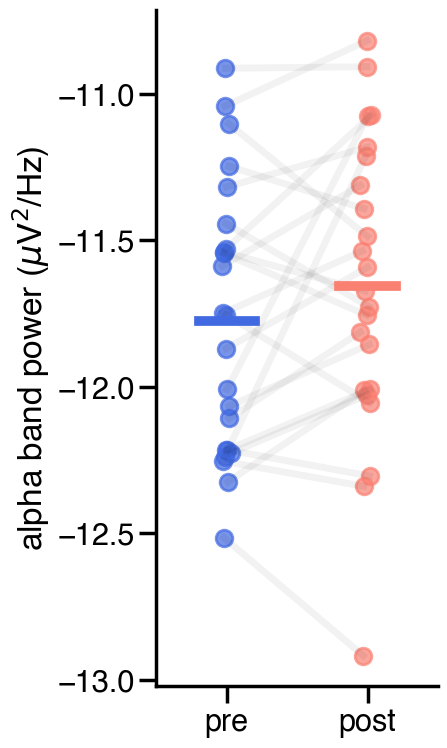

In [15]:
SAVE_FIG = False
fig_path = '../figures/'

# %matplotlib qt

features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'delta_cf', 'theta_amp', 'theta_bp', 'theta_cf',
            'alpha_cf', 'alpha_amp', 'alpha_bp']

labels = ['aperiodic exponent ($\mu$V$^2$/Hz)', 'aperiodic offset ($\mu$V$^2$)',
          'delta oscillation power ($\mu$V$^2$)', 'delta band power ($\mu$V$^2$/Hz)', 'delta center frequency (Hz)',
          'theta oscillation power ($\mu$V$^2$)', 'theta band power ($\mu$V$^2$/Hz)', 'theta center frequency (Hz)',
          'alpha center frequency (Hz)', 'alpha oscillation power ($\mu$V$^2$)', 'alpha band power ($\mu$V$^2$/Hz)' ]

for feature, label in zip(features, labels):
    plot_feature_prepost(exp_df_mean, feature=feature)
    plt.ylabel(label)
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    if SAVE_FIG:
        plt.savefig(fig_path+feature+'.pdf', format='pdf')

### Figure-Specific Axes

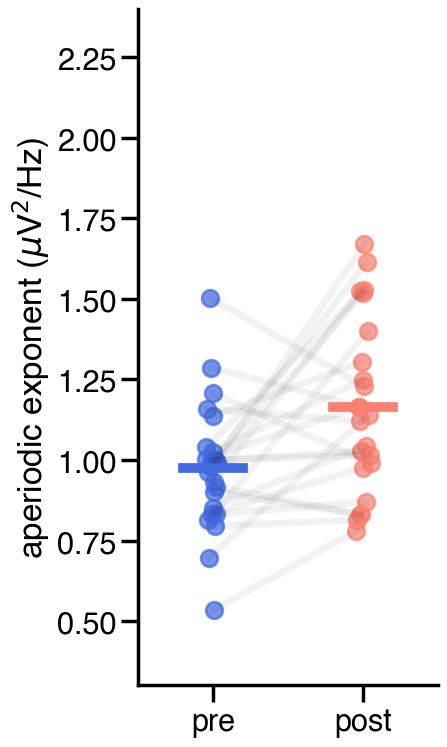

In [16]:
plot_feature_prepost(exp_df_mean, feature='exponent')
plt.ylabel('aperiodic exponent ($\mu$V$^2$/Hz)')
plt.ylim(0.3, 2.4)
sns.despine()
plt.tight_layout()
plt.show()

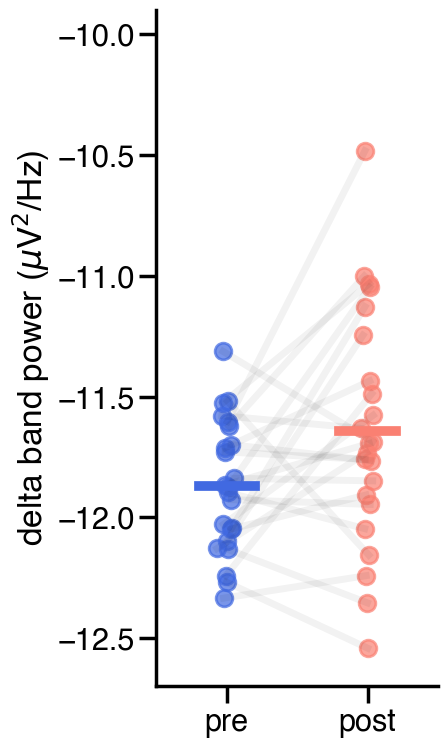

In [17]:
plot_feature_prepost(exp_df_mean, feature='delta_bp')
plt.ylabel('delta band power ($\mu$V$^2$/Hz)')
plt.ylim(-12.7, -9.9)
sns.despine()
plt.tight_layout()
plt.show()

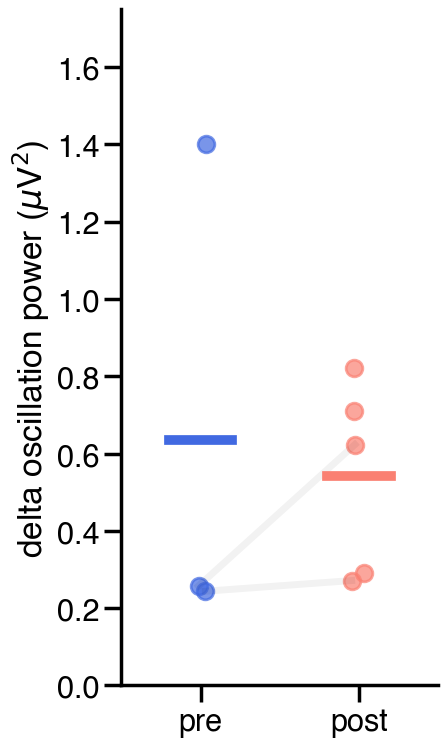

In [18]:
plot_feature_prepost(exp_df_mean, feature='delta_amp')
plt.ylabel('delta oscillation power ($\mu$V$^2$)')
plt.ylim(0, 1.75)
sns.despine()
plt.tight_layout()
plt.show()

## Plot Spectra

In [19]:
fits_pre_mean = np.nanmean(fits_pre_included, axis=1)
fits_post_mean = np.nanmean(fits_post_included, axis=1)

fits_pre_grand_mean = np.nanmean(fits_pre_included, axis=(0,1))
fits_post_grand_mean = np.nanmean(fits_post_included, axis=(0,1))

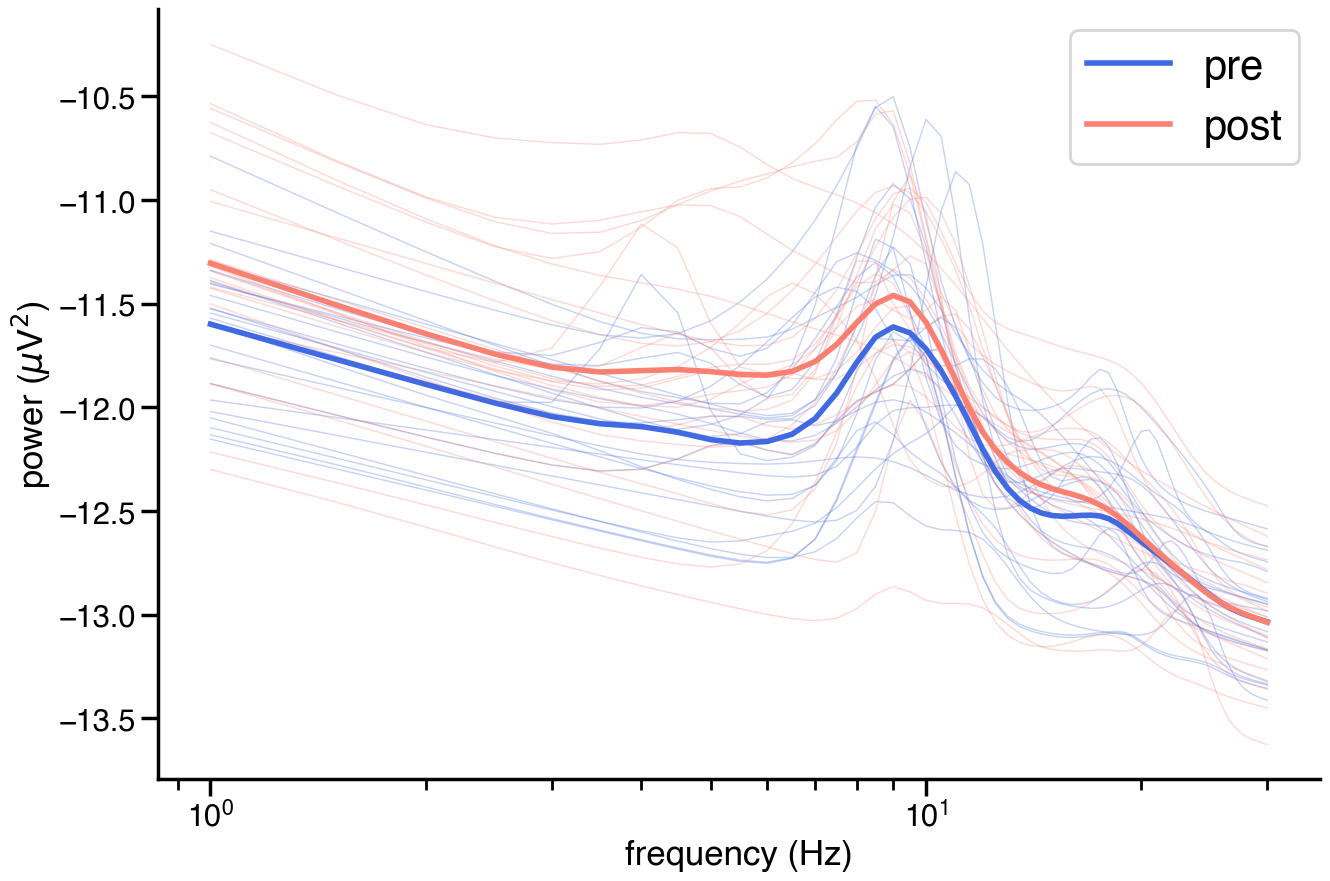

<Figure size 640x480 with 0 Axes>

In [20]:
sns.set_context('poster')
plt.figure(figsize=[15,10])

# plot patient pre
for patient in range(0, fits_pre_mean.shape[0]):
    plt.plot(freq_axis[2:61], fits_pre_mean[patient], color='royalblue', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, fits_post_mean.shape[0]):
    plt.plot(freq_axis[2:61], fits_post_mean[patient], color='salmon', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[2:61], fits_pre_grand_mean, color='royalblue', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[2:61], fits_post_grand_mean, color='salmon', linewidth = 4, label='post')


plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})


sns.despine()

plt.show()
plt.savefig(fig_path+'spectra_fits.pdf', format='pdf')

## Plot SpecParam Fits

In [21]:
psd_pre_mean = np.nanmean(psd_pre_included, axis=1)
psd_post_mean = np.nanmean(psd_post_included, axis=1)

psd_pre_grand_mean = np.nanmean(psd_pre_included, axis=(0,1))
psd_post_grand_mean = np.nanmean(psd_post_included, axis=(0,1))

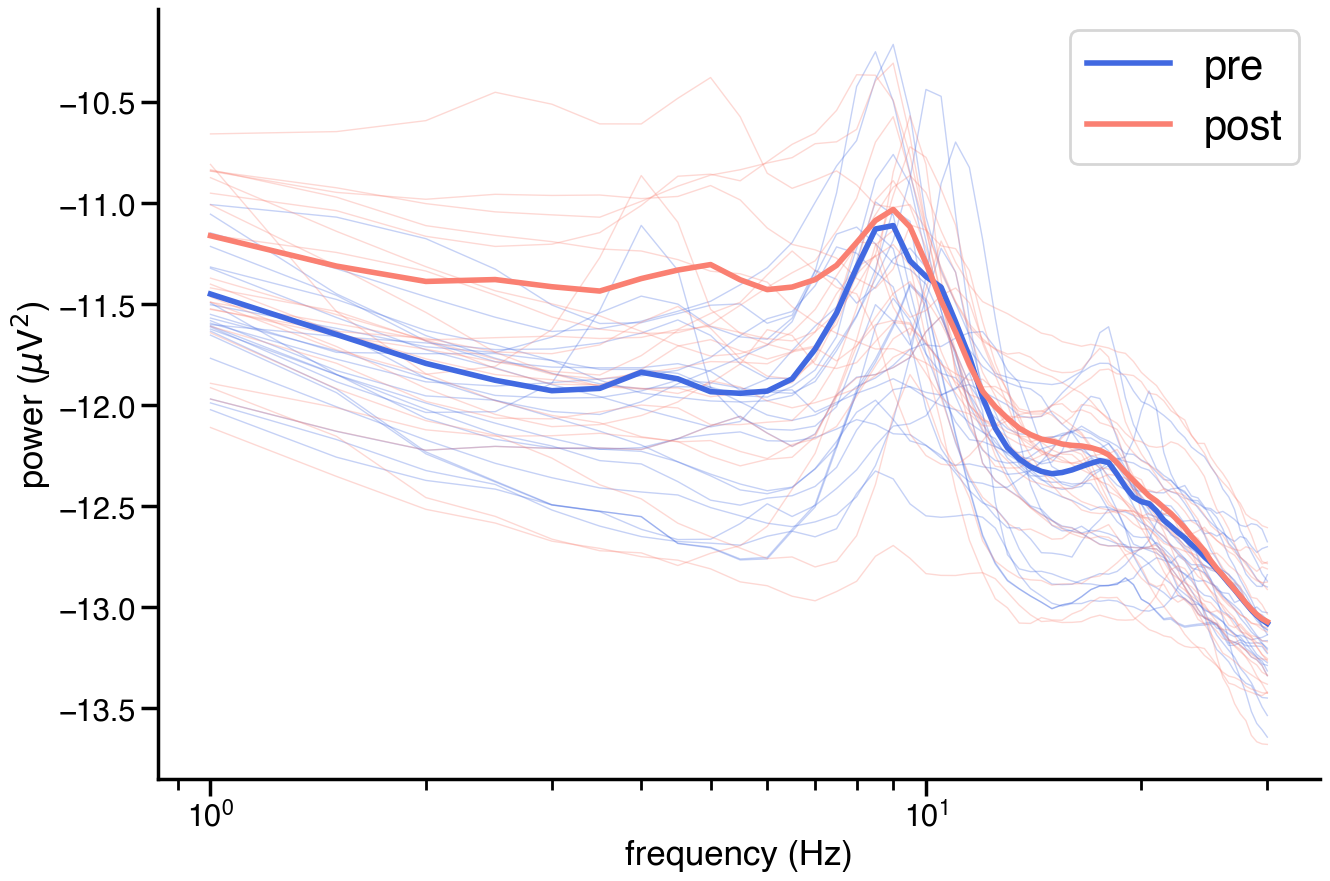

In [22]:
# plot patient pre

sns.set_context('poster')
plt.figure(figsize=[15,10])

for patient in range(0, psd_pre_mean.shape[0]):
    plt.plot(freq_axis[2:61], np.log10(psd_pre_mean[patient,2:61]), color='royalblue', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, psd_post_mean.shape[0]):
    plt.plot(freq_axis[2:61], np.log10(psd_post_mean[patient,2:61]), color='salmon', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[2:61], np.log10(psd_pre_grand_mean[2:61]), color='royalblue', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[2:61], np.log10(psd_post_grand_mean[2:61]), color='salmon', linewidth = 4, label='post')


plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})


sns.despine()

plt.show()

# Statistics

### Exponent: Pre/Post

**Normality**

In [23]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['exponent'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['exponent'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.963124  0.529247    True
          W      pval  normal
0  0.940905  0.187931    True


In [24]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: 0.97 std: 0.2
post: 1.17 std: 0.27


**Distribution of means pre vs. post**

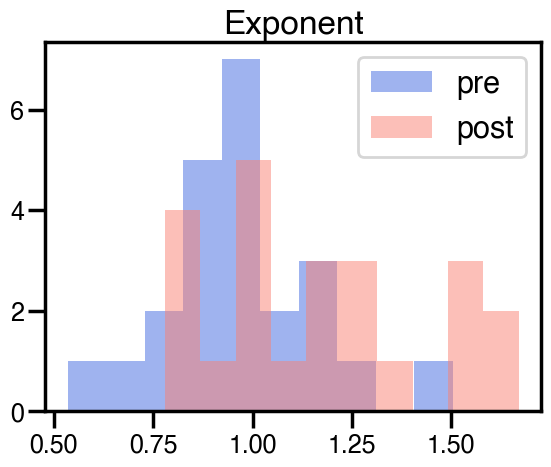

In [25]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Exponent')
plt.show()

**Wilcoxon Test**

In [26]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   55.0   two-sided  0.010109 -0.601449  0.295841


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0144 

               T  dof alternative     p-val           CI95%  cohen-d  BF10  \
T-test -3.170662   22   two-sided  0.004427  [-0.32, -0.07]  0.79761  9.78   

           power  
T-test  0.954821  


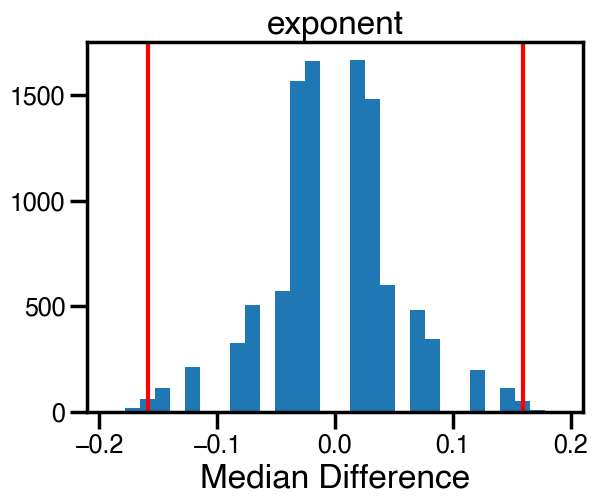

In [27]:
perm_test(exp_df_mean, feature='exponent')

### Offset: Pre/Post

In [28]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['offset'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['offset'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.951168  0.309367    True
          W      pval  normal
0  0.961999  0.504906    True


**Distribution of means pre vs. post**

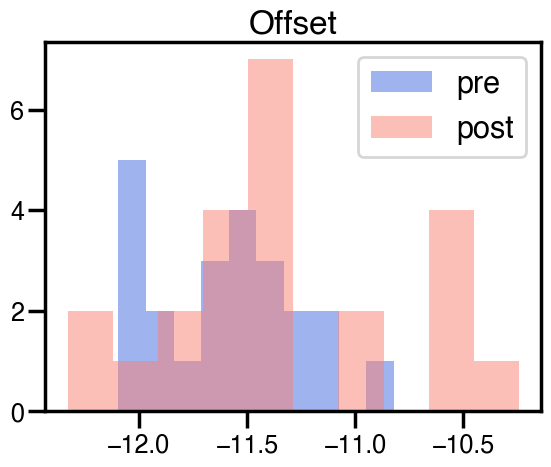

In [29]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Offset')
plt.show()

In [30]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   76.0   two-sided  0.060518 -0.449275  0.356333


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.2437 

               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -2.402345   22   two-sided  0.025169  [-0.49, -0.04]  0.578564  2.289   

          power  
T-test  0.75552  


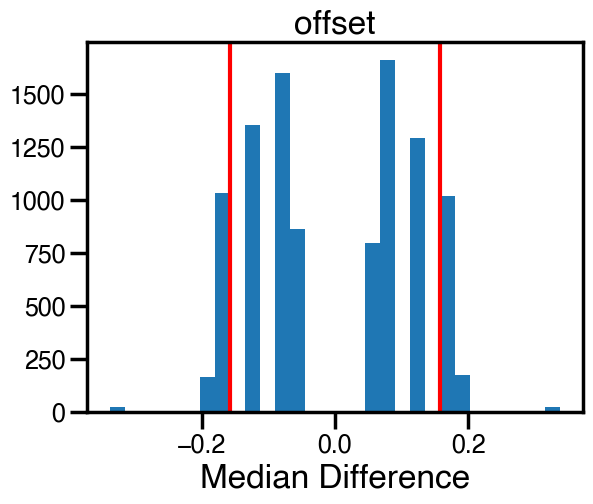

In [31]:
perm_test(exp_df_mean, feature='offset')

### Delta Oscillatory Power: Pre/Post

**Normality**

In [32]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_amp'].values # .dropna(how="any")
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.758904  0.019754   False
          W     pval  normal
0  0.872892  0.27833    True


In [35]:
print('pre: ' + str(round(np.nanmean(means_pre),2)) + ' std: ' + str(round(np.nanstd(means_pre),2)))
print('post: ' + str(round(np.nanmean(means_post),2)) + ' std: ' + str(round(np.nanstd(means_post),2)))

pre: 0.63 std: 0.54
post: 0.54 std: 0.22


**Distribution of means pre vs. post**

This one is tricky to do stats for because the pre has so few channels that even detect a delta oscillation. When we try to keep the 0's instead of NaNs, the Wilcoxon test fails due to 'ties'. Therefore, we are keeping the NaNs, and will just report the permutation test for statistics.

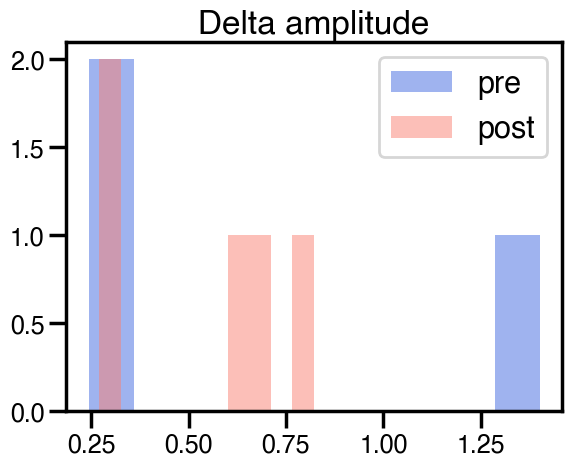

In [36]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta amplitude')
plt.show()

In [37]:
print(wilcoxon(means_pre, means_post))

          W-val alternative  p-val  RBC  CLES
Wilcoxon    0.0   two-sided    0.5 -1.0   0.0


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.163626    1   two-sided  0.451947  [-2.34, 1.95]  1.117331  0.783   

           power  
T-test  0.101722  


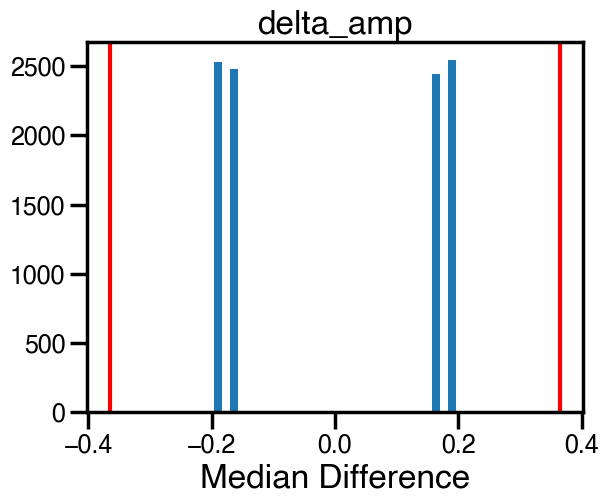

In [38]:
perm_test(exp_df_mean, feature='delta_amp')

### Delta Band Power: Pre/Post

**Normality**

In [39]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W     pval  normal
0  0.974896  0.80381    True
         W      pval  normal
0  0.97931  0.894091    True


In [41]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -11.87 std: 0.27
post: -11.64 std: 0.48


**Distribution of means pre vs. post**

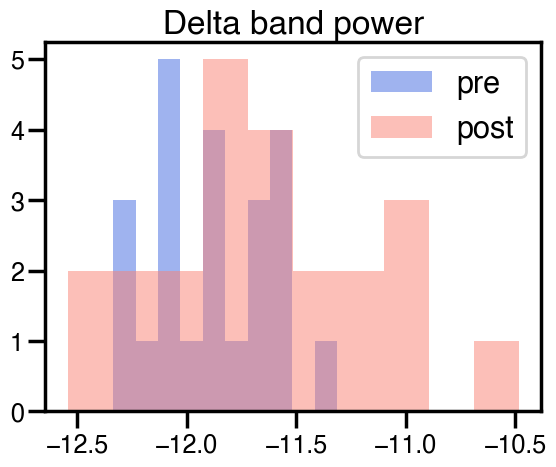

In [42]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta band power')
plt.show()

**Wilcoxon Test**

In [43]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   75.0   two-sided  0.056253 -0.456522  0.358223


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.013399999999999999 

               T  dof alternative     p-val           CI95%   cohen-d  BF10  \
T-test -2.387431   22   two-sided  0.025988  [-0.43, -0.03]  0.577798  2.23   

           power  
T-test  0.754419  


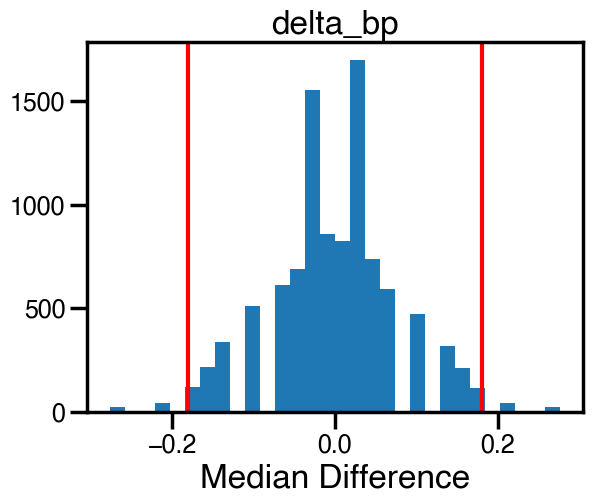

In [44]:
perm_test(exp_df_mean, feature='delta_bp')

### Delta Center Frequency: Pre/Post

**Normality**

In [45]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W     pval  normal
0  0.917999  0.44533    True
          W      pval  normal
0  0.702201  0.010097   False


**Distribution of means pre vs. post**

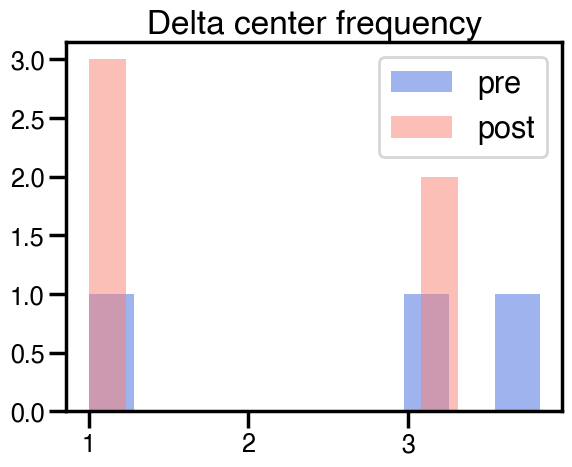

In [46]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta center frequency')
plt.show()

**Wilcoxon Test**

In [47]:
print(wilcoxon(means_pre, means_post))

          W-val alternative  p-val  RBC  CLES
Wilcoxon    0.0   two-sided    0.5  1.0  0.75


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test  1.630027    1   two-sided  0.350317  [-9.03, 11.69]  1.102682  0.932   

           power  
T-test  0.100586  


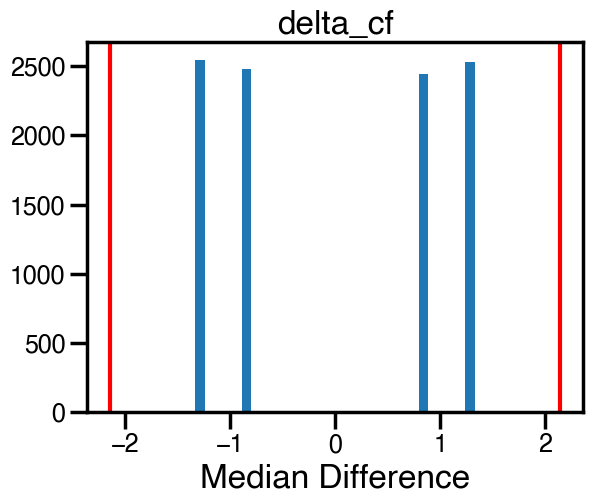

In [48]:
perm_test(exp_df_mean, feature='delta_cf')

### Theta Oscillatory Power: Pre/Post

**Normality**

In [49]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_amp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.883107  0.064362    True
          W      pval  normal
0  0.950538  0.498266    True


In [51]:
print('pre: ' + str(round(np.nanmean(means_pre),2)) + ' std: ' + str(round(np.nanstd(means_pre),2)))
print('post: ' + str(round(np.nanmean(means_post),2)) + ' std: ' + str(round(np.nanstd(means_post),2)))

pre: 0.43 std: 0.18
post: 0.63 std: 0.26


**Distribution of means pre vs. post**

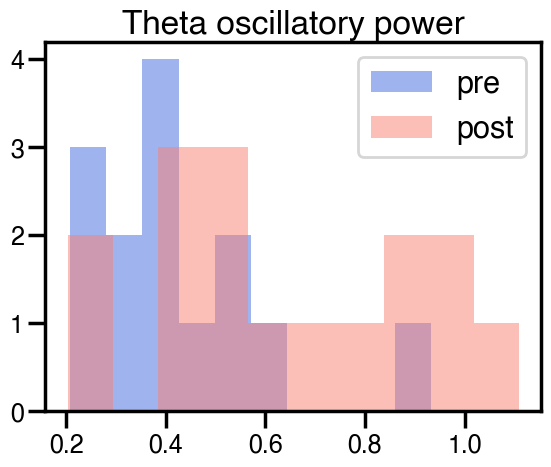

In [52]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta oscillatory power')
plt.show()

**Wilcoxon Test**

In [53]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon    1.0   two-sided  0.000977 -0.974359  0.215278


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.10350000000000001 

               T  dof alternative     p-val           CI95%   cohen-d    BF10  \
T-test -4.710929   11   two-sided  0.000639  [-0.38, -0.14]  1.103478  58.608   

           power  
T-test  0.934776  


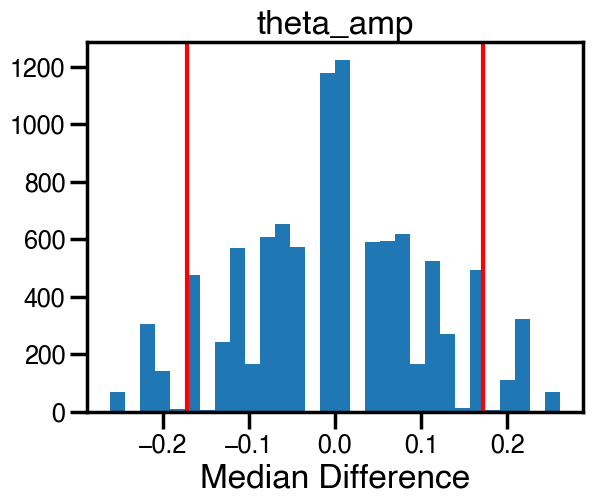

In [54]:
perm_test(exp_df_mean, feature='theta_amp')

### Theta Band Power: Pre/Post

**Normality**

In [55]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.965772  0.588992    True
          W      pval  normal
0  0.981898  0.935787    True


In [56]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -12.11 std: 0.41
post: -11.79 std: 0.61


**Distribution of means pre vs. post**

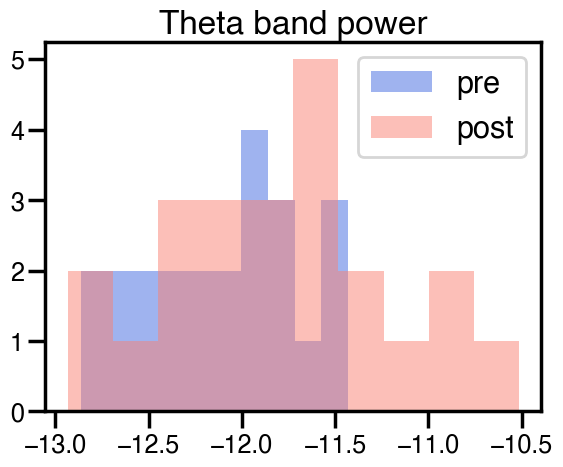

In [57]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta band power')
plt.show()

**Wilcoxon Test**

In [58]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   55.0   two-sided  0.010109 -0.601449  0.337429


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.038400000000000004 

               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -3.145646   22   two-sided  0.004695  [-0.53, -0.11]  0.601066  9.302   

           power  
T-test  0.786668  


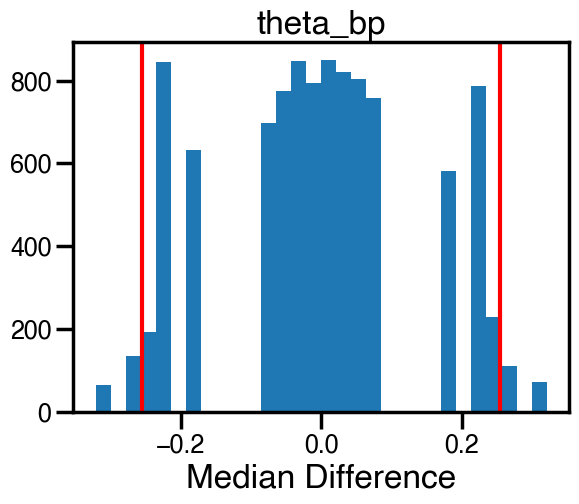

In [59]:
perm_test(exp_df_mean, feature='theta_bp')

### Theta Center Frequency: Pre/Post

**Normality**

In [60]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.913687  0.178243    True
          W      pval  normal
0  0.957234  0.612012    True


**Distribution of means pre vs. post**

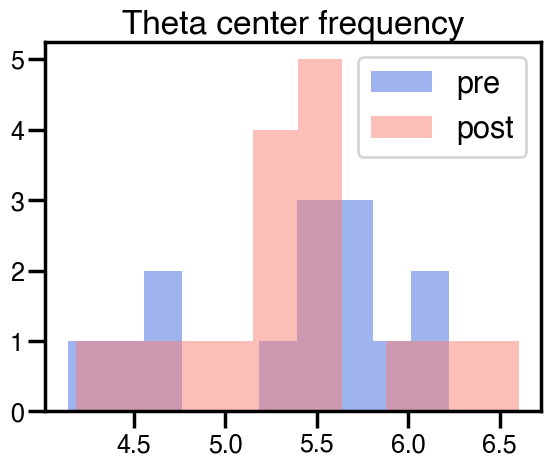

In [61]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta center frequency')
plt.show()

**Wilcoxon Test**

In [62]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   35.0   two-sided  0.791016 -0.102564  0.513889


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.2052 

               T  dof alternative     p-val          CI95%  cohen-d   BF10  \
T-test -0.808071   11   two-sided  0.436177  [-0.57, 0.27]  0.22782  0.379   

           power  
T-test  0.111573  


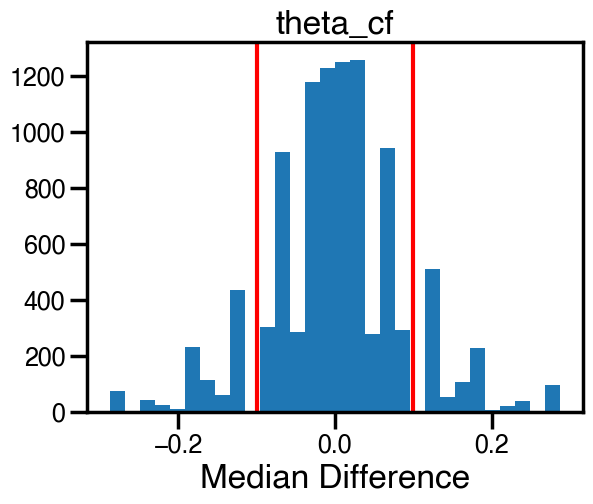

In [63]:
perm_test(exp_df_mean, feature='theta_cf')

### Alpha Oscillatory Power: Pre/Post

**Normality**

In [64]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_amp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.951616  0.316001    True
          W      pval  normal
0  0.977139  0.852133    True


In [66]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: 1.04 std: 0.46
post: 1.02 std: 0.39


**Distribution of means pre vs. post**

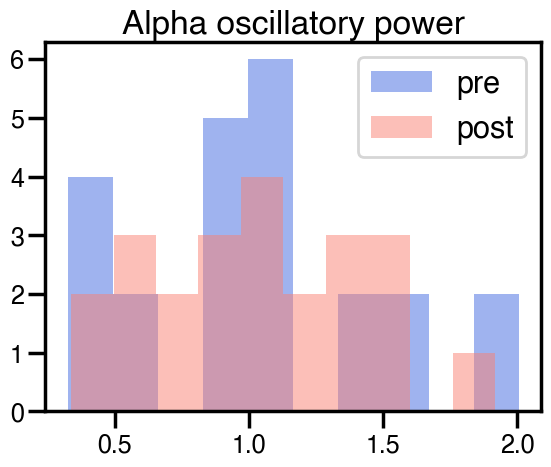

In [67]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha oscillatory power')
plt.show()

**Wilcoxon Test**

In [68]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon  124.0   two-sided  0.686879  0.101449  0.507561


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.6553 

               T  dof alternative     p-val          CI95%  cohen-d   BF10  \
T-test  0.213846   22   two-sided  0.832637  [-0.13, 0.16]  0.03537  0.223   

           power  
T-test  0.053025  


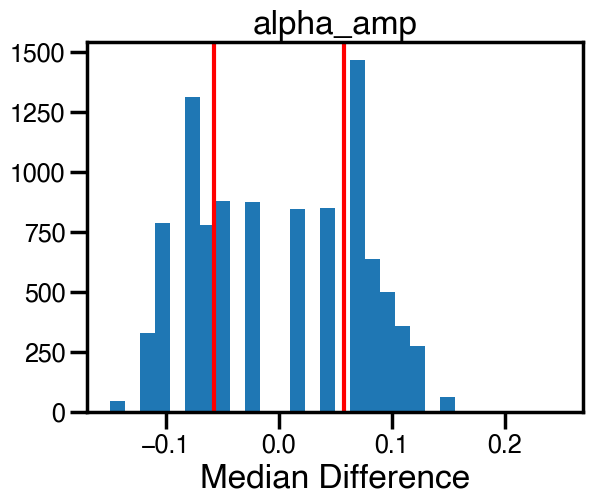

In [69]:
perm_test(exp_df_mean, feature='alpha_amp')

### Alpha Band Power: Pre/Post

**Normality**

In [70]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.947879  0.264291    True
          W      pval  normal
0  0.975392  0.814861    True


In [71]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -11.78 std: 0.45
post: -11.66 std: 0.5


**Distribution of means pre vs. post**

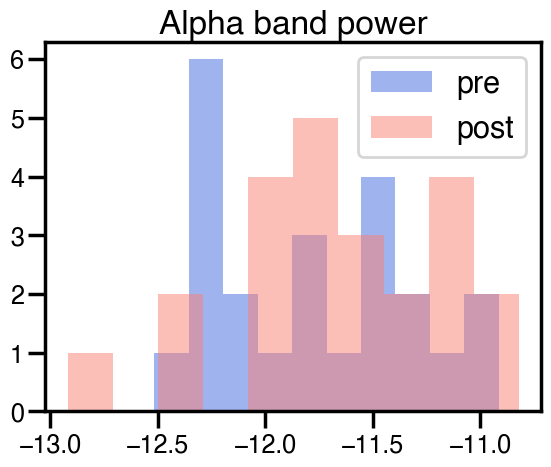

In [72]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha band power')
plt.show()

**Wilcoxon Test**

In [73]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   95.0   two-sided  0.200155 -0.311594  0.414934


**Permutation Test + T-Test**

The probability from the sampling statistics is =  0.8251 

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.552687   22   two-sided  0.134766  [-0.28, 0.04]  0.244632  0.623   

           power  
T-test  0.202177  


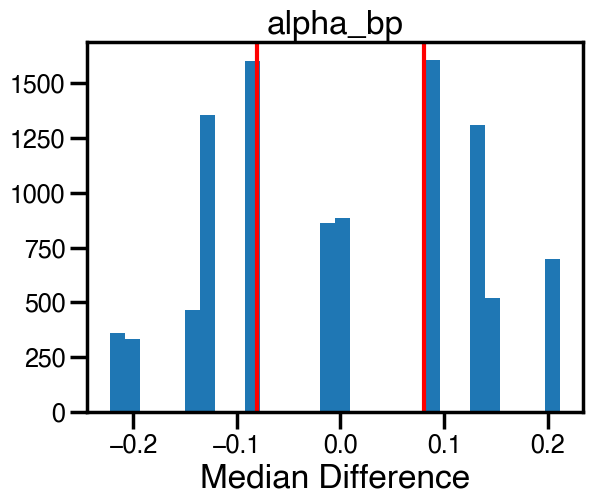

In [74]:
perm_test(exp_df_mean, feature='alpha_bp')

### Alpha Center Frequency: Pre/Post

**Normality**

In [75]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.974818  0.802066    True
         W      pval  normal
0  0.95934  0.450171    True


**Distribution of means pre vs. post**

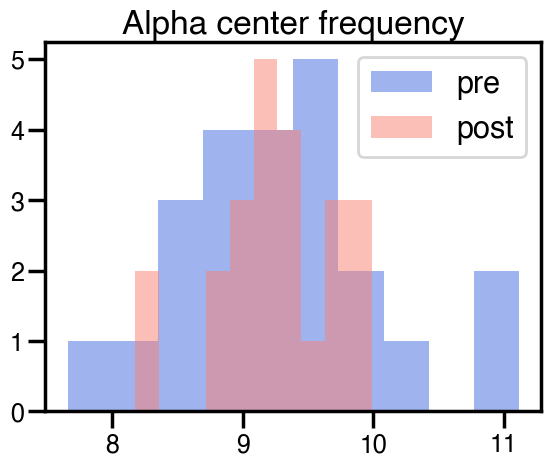

In [76]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha center frequency')
plt.show()

**Wilcoxon Test**

In [77]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon  137.0   two-sided  0.988101  0.007246  0.482987


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.24580000000000002 

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  0.213443   22   two-sided  0.832947  [-0.21, 0.25]  0.035337  0.223   

           power  
T-test  0.053019  


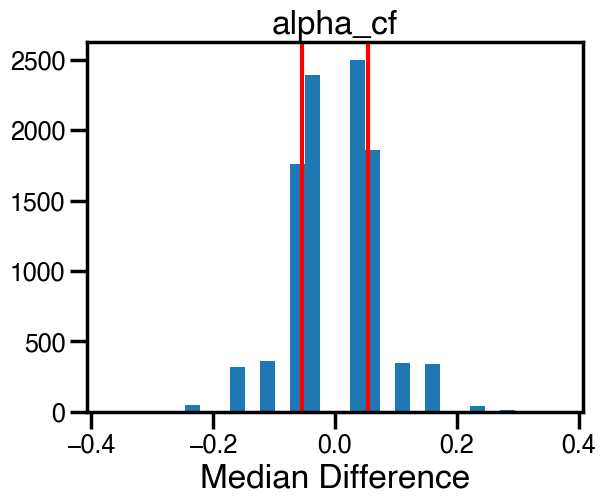

In [78]:
perm_test(exp_df_mean, feature='alpha_cf')

## Presence/Absence/Percentage of Channels with Oscillations

We are determining what % of channels have a delta oscillation per participant, per pre/post

### Delta Percentage

In [79]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a delta oscillation)

features = ['patient','pre_post','channel','delta_cf']
exp_df_delta_osc = exp_df_included[features]
exp_df_delta_osc['delta_present'] = exp_df_delta_osc['delta_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_1789/259686611.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_delta_osc['delta_present'] = exp_df_delta_osc['delta_cf'].notna()


In [80]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a delta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_delta = exp_df_delta_osc.groupby(['patient', 'pre_post'])['delta_present'].sum().values
ch_total = exp_df_delta_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_delta_perc = ch_delta/ch_total

In [81]:
# Add the delta oscillation percentages to the other df to determine which value corresponds to pre/post

delta_osc_perc = pd.DataFrame(exp_df_delta_osc.groupby(['patient', 'pre_post'], as_index=False)['delta_present'].sum())
delta_osc_perc['ch_delta_perc'] = ch_delta_perc

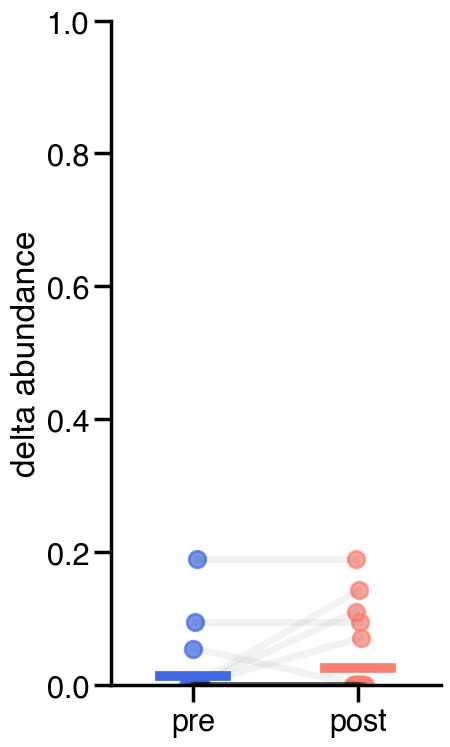

In [82]:
plot_feature_prepost(delta_osc_perc, feature='ch_delta_perc')
plt.ylim(0, 1) # same y axis as ECT
plt.ylabel('delta abundance')
sns.despine()
plt.show()

**Normality**

In [83]:
perc_delta_pre = delta_osc_perc[delta_osc_perc['pre_post']=='pre']['ch_delta_perc'].values
perc_delta_post = delta_osc_perc[delta_osc_perc['pre_post']=='post']['ch_delta_perc'].values

# normality test
print(normality(perc_delta_pre, method='shapiro'))
print(normality(perc_delta_post, method='shapiro'))

          W          pval  normal
0  0.393198  9.460021e-09   False
          W          pval  normal
0  0.555313  3.026340e-07   False


In [84]:
print('pre: ' + str(round(perc_delta_pre.mean(),2)) + ' std: ' + str(round(perc_delta_pre.std(),2)))
print('post: ' + str(round(perc_delta_post.mean(),2)) + ' std: ' + str(round(perc_delta_post.std(),2)))

pre: 0.01 std: 0.04
post: 0.03 std: 0.05


**Wilcoxon Test**

In [85]:
print(wilcoxon(perc_delta_pre, perc_delta_post))

          W-val alternative     p-val  RBC      CLES
Wilcoxon    1.0   two-sided  0.201243 -0.8  0.453686


/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


**Permutation Test & T-Test**

The probability from the sampling statistics is =  2.0 

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.357829   22   two-sided  0.188283  [-0.03, 0.01]  0.234278  0.491   

           power  
T-test  0.189283  


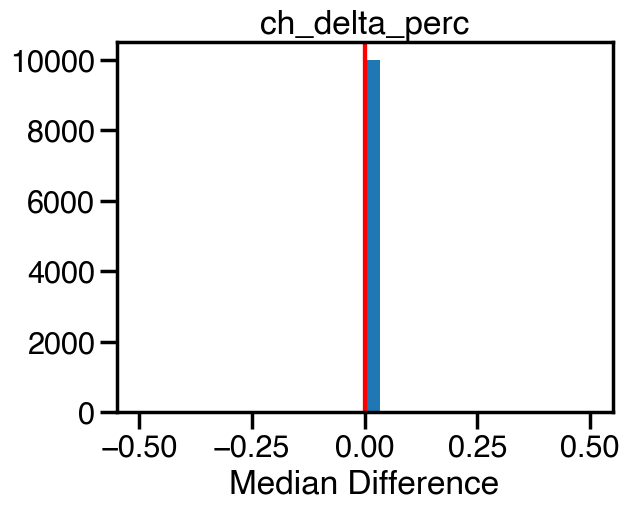

In [86]:
perm_test(delta_osc_perc, feature='ch_delta_perc')

### Theta Percentage

In [87]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a theta oscillation)

features = ['patient','pre_post','channel','theta_cf']
exp_df_theta_osc = exp_df_included[features]
exp_df_theta_osc['theta_present'] = exp_df_theta_osc['theta_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_1789/2939216184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_theta_osc['theta_present'] = exp_df_theta_osc['theta_cf'].notna()


In [88]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a theta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_theta = exp_df_theta_osc.groupby(['patient', 'pre_post'])['theta_present'].sum().values
ch_total = exp_df_theta_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_theta_perc = ch_theta/ch_total

In [89]:
# Add the theta oscillation percentages to the other df to determine which value corresponds to pre/post

theta_osc_perc = pd.DataFrame(exp_df_theta_osc.groupby(['patient', 'pre_post'], as_index=False)['theta_present'].sum())
theta_osc_perc['ch_theta_perc'] = ch_theta_perc

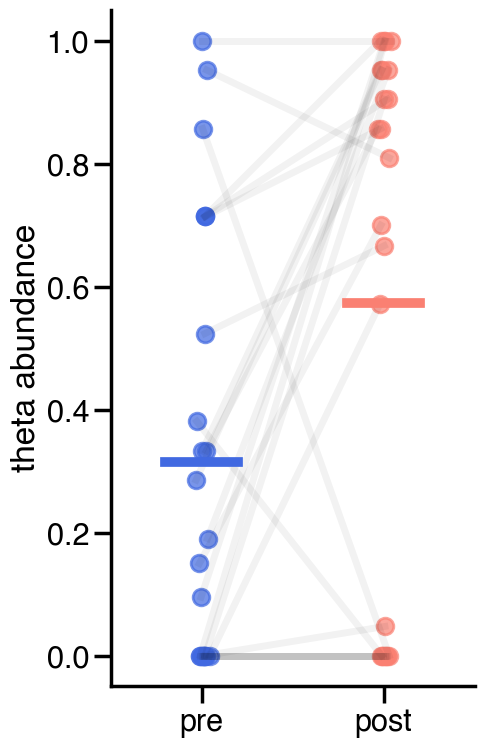

In [90]:
plot_feature_prepost(theta_osc_perc, feature='ch_theta_perc')
plt.ylabel('theta abundance')
sns.despine()
plt.show()

In [94]:
perc_theta_pre = theta_osc_perc[theta_osc_perc['pre_post']=='pre']['ch_theta_perc'].values
perc_theta_post = theta_osc_perc[theta_osc_perc['pre_post']=='post']['ch_theta_perc'].values

In [96]:
print('pre: ' + str(round(perc_theta_pre.mean(),2)) + ' std: ' + str(round(perc_theta_pre.std(),2)))
print('post: ' + str(round(perc_theta_post.mean(),2)) + ' std: ' + str(round(perc_theta_post.std(),2)))

pre: 0.32 std: 0.34
post: 0.57 std: 0.43


**Wilcoxon Test**

In [97]:
print(wilcoxon(perc_theta_pre, perc_theta_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   24.0   two-sided  0.013766 -0.686275  0.340265


/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative     p-val           CI95%   cohen-d  BF10  \
T-test -2.740341   22   two-sided  0.011944  [-0.45, -0.06]  0.652164  4.23   

           power  
T-test  0.848175  


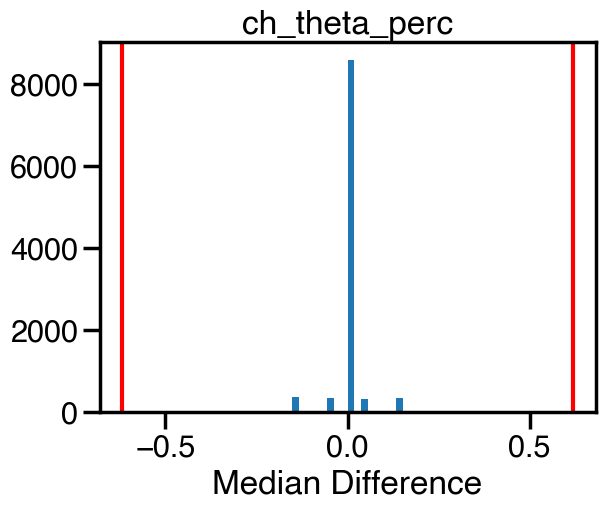

In [98]:
perm_test(theta_osc_perc, feature='ch_theta_perc')

### Alpha Percentage

In [99]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have an alpha oscillation)

features = ['patient','pre_post','channel','alpha_cf']
exp_df_alpha_osc = exp_df_included[features]
exp_df_alpha_osc['alpha_present'] = exp_df_alpha_osc['alpha_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_1789/4032763983.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_alpha_osc['alpha_present'] = exp_df_alpha_osc['alpha_cf'].notna()


In [100]:
# With this new df, we want to group by the patient/pre_post to show how many channels have an alpha oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_alpha = exp_df_alpha_osc.groupby(['patient', 'pre_post'])['alpha_present'].sum().values
ch_total = exp_df_alpha_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_alpha_perc = ch_alpha/ch_total

In [101]:
# Add the alpha oscillation percentages to the other df to determine which value corresponds to pre/post

alpha_osc_perc = pd.DataFrame(exp_df_alpha_osc.groupby(['patient', 'pre_post'], as_index=False)['alpha_present'].sum())
alpha_osc_perc['ch_alpha_perc'] = ch_alpha_perc

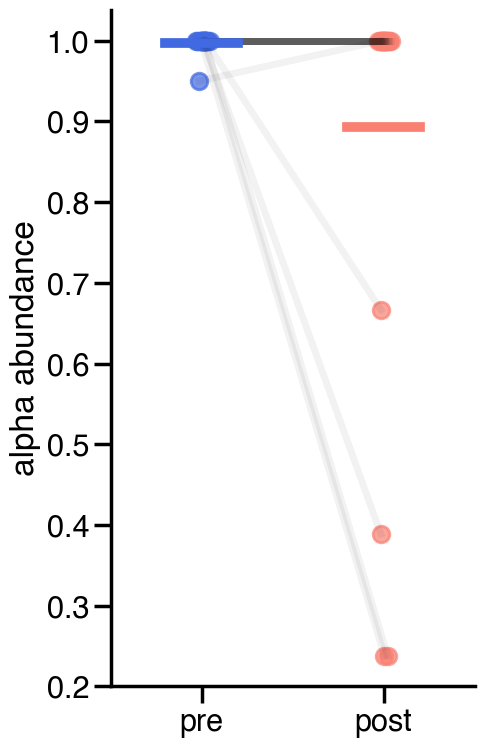

In [102]:
plot_feature_prepost(alpha_osc_perc, feature='ch_alpha_perc')
plt.ylabel('alpha abundance')
sns.despine()
plt.show()

In [103]:
perc_alpha_pre = alpha_osc_perc[alpha_osc_perc['pre_post']=='pre']['ch_alpha_perc'].values
perc_alpha_post = alpha_osc_perc[alpha_osc_perc['pre_post']=='post']['ch_alpha_perc'].values

In [104]:
print('pre: ' + str(round(perc_alpha_pre.mean(),2)) + ' std: ' + str(round(perc_alpha_pre.std(),2)))
print('post: ' + str(round(perc_alpha_post.mean(),2)) + ' std: ' + str(round(perc_alpha_post.std(),2)))

pre: 1.0 std: 0.01
post: 0.89 std: 0.25


**Wilcoxon Test**

In [105]:
print(wilcoxon(perc_alpha_pre, perc_alpha_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon    1.0   two-sided  0.104059  0.866667  0.568998


/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


**Permutation Test & T-Test**

The probability from the sampling statistics is =  2.0 

               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  2.003309   22   two-sided  0.057614  [-0.0, 0.21]  0.593031  1.182   

           power  
T-test  0.775821  


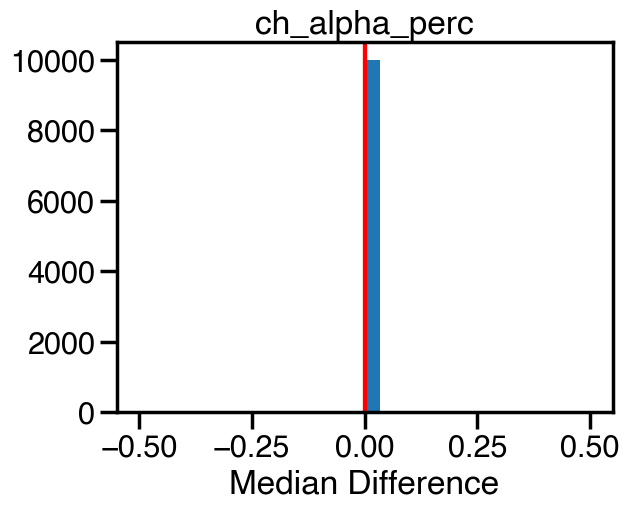

In [106]:
perm_test(alpha_osc_perc, feature='ch_alpha_perc')

## Merge Percentage Oscillation Dataframes

In [107]:
# merge percentage dfs
perc_df = pd.merge(theta_osc_perc, delta_osc_perc, how='outer', on=['patient', 'pre_post'])
perc_df = pd.merge(perc_df, alpha_osc_perc, how='outer', on=['patient', 'pre_post'])

In [108]:
# merge perc with main eeg feature df
exp_df_mean_wperc = pd.merge(exp_df_mean, perc_df, how='outer', on=['patient', 'pre_post'])

In [109]:
exp_df_mean_wperc.head()

,patient,pre_post,exponent,offset,delta_amp,delta_bp,theta_amp,theta_bp,theta_cf,delta_cf,alpha_amp,alpha_bp,alpha_bw,alpha_cf,theta_present,ch_theta_perc,delta_present,ch_delta_perc,alpha_present,ch_alpha_perc
0,9,post,1.228226,-11.299618,NaN,-11.686527,0.557512,-11.704801,5.309427,NaN,0.976951,-11.727461,2.907741,9.378665,20,0.952381,0,0.000000,21,1.000000
1,9,pre,1.504267,-10.821567,NaN,-11.313215,0.565246,-11.463855,5.646399,NaN,0.911315,-11.443717,4.914359,9.326471,4,0.190476,0,0.000000,21,1.000000
2,10,post,0.829237,-12.327138,0.710363,-12.541443,NaN,-12.933178,NaN,1.0,0.338506,-12.918370,1.756300,9.384808,0,0.000000,2,0.111111,7,0.388889
3,10,pre,0.902133,-11.978239,NaN,-12.268109,NaN,-12.612165,NaN,NaN,0.410040,-12.515883,3.482577,9.628579,0,0.000000,0,0.000000,18,1.000000
4,18,post,1.165371,-11.329104,NaN,-11.631732,NaN,-12.079812,NaN,NaN,0.971544,-11.673647,2.173723,9.192352,0,0.000000,0,0.000000,21,1.000000


## Multiple Regression Spectral Analysis

What EEG features may be predictive of other EEG features? Specifically, what might be driving the band power differences pre vs. post?

### Using Treatment Difference

**Take difference of pre - post**

In [110]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_cf', 'ch_theta_perc', 'ch_delta_perc', 'ch_alpha_perc']


diff_df_mean_wperc = exp_df_mean_wperc.groupby(['patient'], as_index=False)[features].diff().dropna(0, how='all')
diff_df_mean_wperc['patient'] = exp_df_mean_wperc['patient']

diff_df_mean_wperc

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_1789/1529135655.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  diff_df_mean_wperc = exp_df_mean_wperc.groupby(['patient'], as_index=False)[features].diff().dropna(0, how='all')


,exponent,offset,delta_amp,delta_bp,theta_amp,theta_bp,theta_cf,delta_cf,alpha_amp,alpha_bp,alpha_cf,ch_theta_perc,ch_delta_perc,ch_alpha_perc,patient
1,0.276041,0.478052,NaN,0.373313,0.007734,0.240946,0.336972,NaN,-0.065636,0.283744,-0.052195,-0.761905,0.000000,0.000000,9
3,0.072895,0.348899,NaN,0.273335,NaN,0.321013,NaN,NaN,0.071534,0.402487,0.243771,0.000000,-0.111111,0.611111,10
5,0.121509,0.175104,NaN,0.052658,NaN,0.314615,NaN,NaN,0.098326,0.133016,-0.645699,0.380952,0.000000,0.000000,18
7,-0.585788,-0.947842,NaN,-0.753291,NaN,-0.700548,NaN,NaN,-0.483526,-0.933224,0.836061,0.857143,0.000000,0.000000,22
9,-0.027925,0.445921,NaN,0.636084,NaN,0.312491,NaN,NaN,-0.808540,-0.274807,-0.779126,-0.047619,0.000000,0.000000,25
11,-0.525964,-0.590935,NaN,-0.493746,-0.397860,-0.596762,0.344943,NaN,0.120991,-0.005346,-0.030391,-0.285714,0.000000,0.000000,33
13,-0.015692,0.067820,NaN,0.010670,-0.554424,-0.073075,-0.865817,NaN,0.276545,0.301135,-0.511934,-0.904762,-0.142857,0.761905,35
15,-0.243568,-0.338751,NaN,-0.451774,NaN,-0.174846,NaN,NaN,-0.145740,-0.199701,-0.072597,0.000000,0.000000,0.000000,40
17,-0.037022,0.081668,NaN,0.031205,-0.088483,0.011331,-0.099247,NaN,0.045084,0.144225,-0.053991,-0.619048,0.000000,0.000000,46
19,0.216145,0.330299,-0.027656,0.149814,NaN,0.339165,NaN,2.143993,-0.307139,0.089466,-0.663765,0.000000,0.000000,0.000000,47


In [111]:
# multiple linear regression to see where changes in delta & theta come from
model = ols('delta_bp ~ exponent + ch_delta_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               delta_bp   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     26.21
Date:                Wed, 08 Feb 2023   Prob (F-statistic):           2.58e-06
Time:                        15:02:05   Log-Likelihood:                0.45555
No. Observations:                  23   AIC:                             5.089
Df Residuals:                      20   BIC:                             8.495
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0062      0.069     -0.089

In [112]:
model = ols('theta_bp ~ exponent + ch_theta_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               theta_bp   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     23.78
Date:                Wed, 08 Feb 2023   Prob (F-statistic):           5.16e-06
Time:                        15:02:05   Log-Likelihood:                -1.6504
No. Observations:                  23   AIC:                             9.301
Df Residuals:                      20   BIC:                             12.71
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0207      0.077     -0.270

In [113]:
model = ols('alpha_bp ~ exponent + alpha_amp + ch_alpha_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               alpha_bp   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     5.492
Date:                Wed, 08 Feb 2023   Prob (F-statistic):            0.00688
Time:                        15:02:06   Log-Likelihood:                -1.8862
No. Observations:                  23   AIC:                             11.77
Df Residuals:                      19   BIC:                             16.31
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0043      0.078     -0.056

/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='theta_amp', ylabel='theta_bp'>

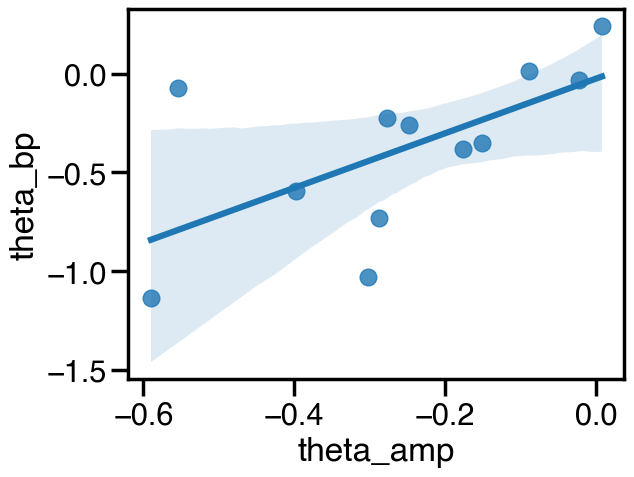

In [114]:
sns.regplot(diff_df_mean_wperc['theta_amp'], diff_df_mean_wperc['theta_bp'])

/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ch_theta_perc', ylabel='theta_bp'>

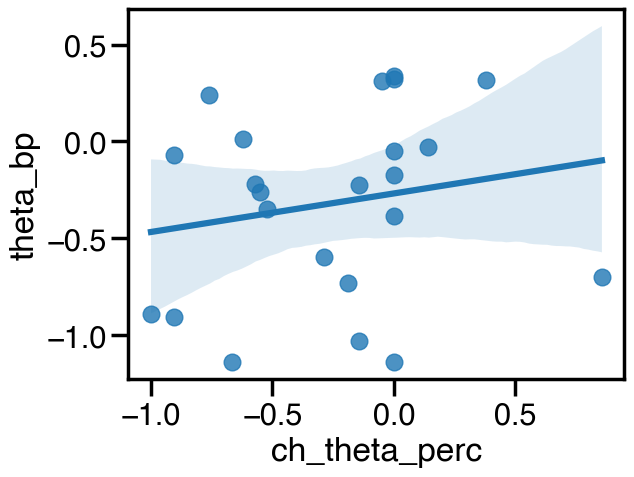

In [115]:
sns.regplot(diff_df_mean_wperc['ch_theta_perc'], diff_df_mean_wperc['theta_bp'])

/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='offset', ylabel='theta_bp'>

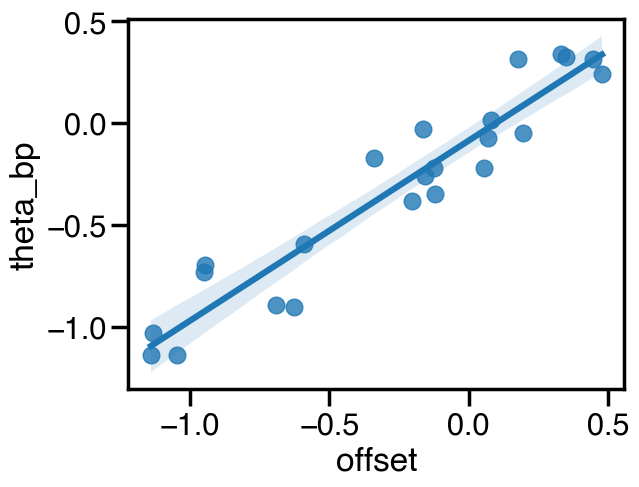

In [116]:
sns.regplot(diff_df_mean_wperc['offset'], diff_df_mean_wperc['theta_bp'])

/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='theta_bp'>

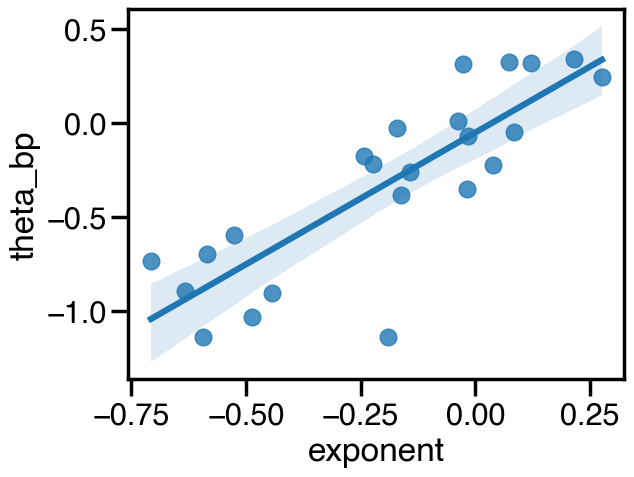

In [117]:
sns.regplot(diff_df_mean_wperc['exponent'], diff_df_mean_wperc['theta_bp'])